In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
import nltk.corpus
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords

import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import defaultdict,Counter

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data exploration

#### Initial exploration

In [2]:
# General overview of the dataset
dataframe = pd.read_csv('justice.csv', index_col=0)
print("Shape of dataframe:", dataframe.shape)# look for the amount of numbers in the data
dataframe.term.value_counts()
print("")
print("Dataframe innformation:", dataframe.info())
print("")
print("First 5 rows of the dataframe: \n")
dataframe.head(5)

Shape of dataframe: (3303, 15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3303 entries, 0 to 3302
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  3303 non-null   int64 
 1   name                3303 non-null   object
 2   href                3303 non-null   object
 3   docket              3303 non-null   object
 4   term                3303 non-null   object
 5   first_party         3302 non-null   object
 6   second_party        3302 non-null   object
 7   facts               3303 non-null   object
 8   facts_len           3303 non-null   int64 
 9   majority_vote       3303 non-null   int64 
 10  minority_vote       3303 non-null   int64 
 11  first_party_winner  3288 non-null   object
 12  decision_type       3296 non-null   object
 13  disposition         3231 non-null   object
 14  issue_area          3161 non-null   object
dtypes: int64(4), object(11)
memory usage: 41

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


In [3]:
# Check if the text contains numbers
dataframe.term.value_counts()

1997         97
1996         91
2009         87
2005         86
2000         86
             ..
1957         16
1959         10
1789-1850    10
1850-1900     8
1955          5
Name: term, Length: 70, dtype: int64

There are several numbers in the text. These will be removed in the pre processing section.

In [4]:
# Describe the variables that will be used for prediction
data=dataframe.loc[:, ['facts', 'first_party_winner', 'first_party', 'second_party']]
data.describe()

,facts,first_party_winner,first_party,second_party
count,3303,3288,3302,3302
unique,3302,2,2764,2556
top,"<p>In 1952, Arizona invoked the U.S. Supreme C...",True,United States,United States
freq,2,2140,201,314


#### Missing values

In [5]:
# Look for missing values
print("Number of missing values per attribute: \n", dataframe.isnull().sum().sort_values(ascending=False))

Number of missing values per attribute: 
 issue_area            142
disposition            72
first_party_winner     15
decision_type           7
first_party             1
second_party            1
ID                      0
name                    0
href                    0
docket                  0
term                    0
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
dtype: int64


The class variable (first_party_winner), and two predictive variables has missing values (first_party and second_party) have missing values, so we will remove them. 

In [6]:
# Remove missing values from predictor variables
dataframe=dataframe.dropna(subset=['first_party_winner'])
dataframe=dataframe.dropna(subset=['first_party'])
dataframe=dataframe.dropna(subset=['second_party'])

#### Class distribution

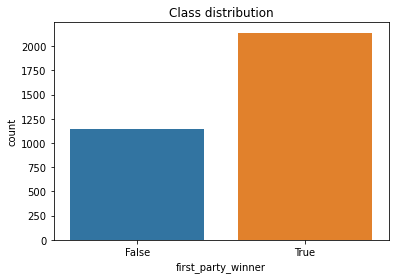

In [7]:
# Distribution of class
sns.countplot(x='first_party_winner',data=dataframe)
plt.title("Class distribution")
plt.rcParams.update({'font.size': 5})
plt.show()

The graph shows that there are more cases in the dataset in which the first party won.

#### Frequency of each decision type

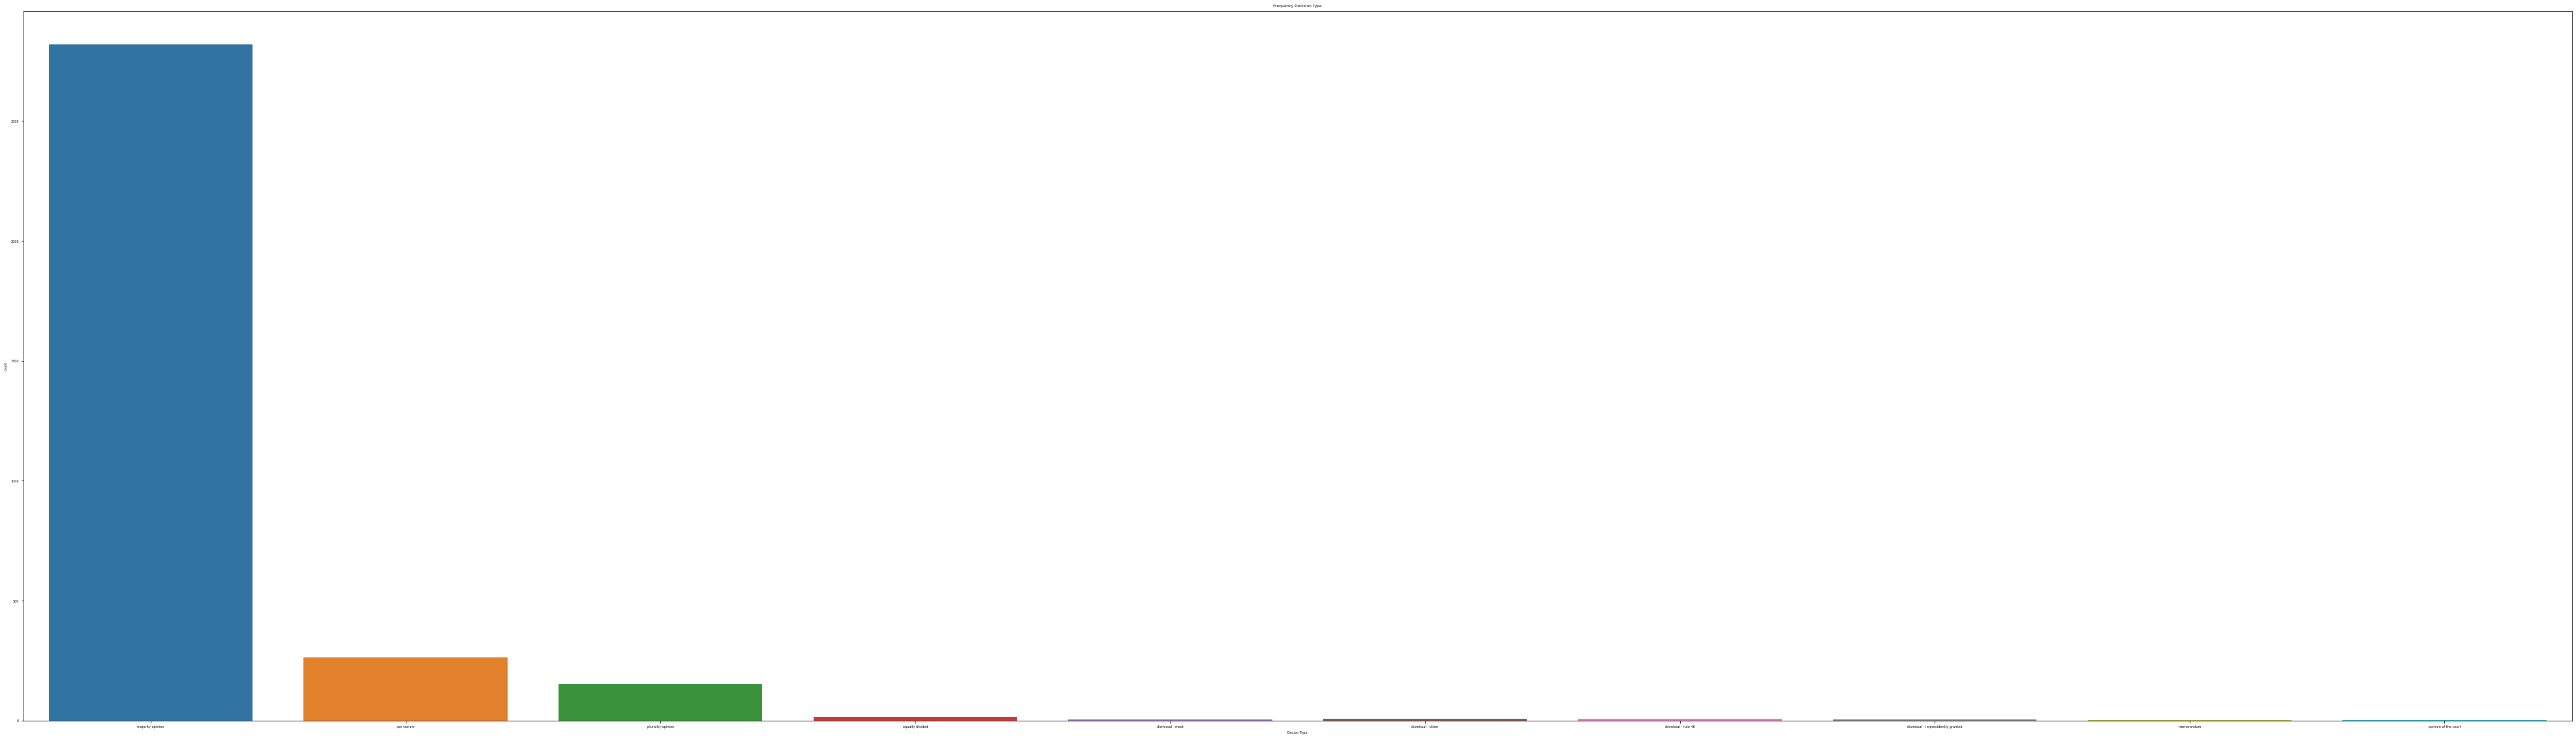

In [8]:
# Frequency of each decision type
plt.figure(figsize=(70,20))
sns.countplot(x='decision_type',data=dataframe)
plt.title("Frequency Decision Type")
plt.xlabel("Decion Type")
plt.rcParams.update({'font.size': 50})
plt.show()

In most of the cases the decision was made based on the majority opinion, followed by per curiam (collective jury) and plurality opinion. 

#### Most common words

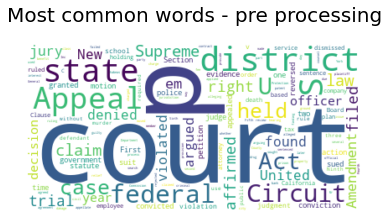

In [9]:
# Create a word cloud to visually discover the most frequent words in the variable facts 
words = " ".join(text for text in dataframe['facts'])
words_cloud = WordCloud(background_color = 'white', max_words=150, collocations = False).generate(words)

plt.imshow(words_cloud, interpolation='bilinear')
plt.title('Most common words - pre processing', fontsize=20, y=1.1)
plt.axis("off");

Court, district, state and appeal appear among the most common words. However there are some other characters (such as 'p') that should be removed

## Data preprocessing

#### Removing punctuation

In [10]:
# First, the character <p> is manually removed, as it was seen that it appears at the beginning of each fact
# Then the rest of punctuations are removed using the already provided set of punctuation (string.punctuation). 
dataframe['facts']= dataframe['facts'].str.replace(r'<p>', '', regex=True)
dataframe['facts']= dataframe['facts'].str.translate(str.maketrans('','',string.punctuation))
dataframe['first_party']= dataframe['first_party'].str.translate(str.maketrans('','',string.punctuation))
dataframe['second_party']= dataframe['second_party'].str.translate(str.maketrans('','',string.punctuation))


It can be seen that the noise in the text has disappeared

####  Removing numbers

In [11]:
# Replace digits with nothing
dataframe['facts'] = dataframe['facts'].str.replace('\d+', '')
dataframe['first_party'] = dataframe['first_party'].str.replace('\d+', '')
dataframe['second_party'] = dataframe['second_party'].str.replace('\d+', '')

<ipython-input-11-a2aa76d89744>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['facts'] = dataframe['facts'].str.replace('\d+', '')
<ipython-input-11-a2aa76d89744>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['first_party'] = dataframe['first_party'].str.replace('\d+', '')
<ipython-input-11-a2aa76d89744>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['second_party'] = dataframe['second_party'].str.replace('\d+', '')


####  Removing extra spaces

In [12]:
#Replace double spaces with only one space
dataframe['facts']= dataframe['facts'].str.replace('  ', ' ', regex=True)
dataframe['first_party']= dataframe['first_party'].str.replace('  ', ' ', regex=True)
dataframe['second_party']= dataframe['second_party'].str.replace('  ', ' ', regex=True)

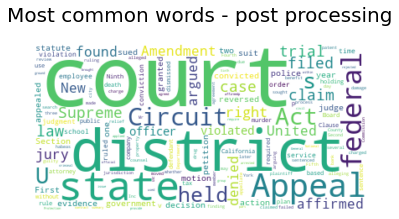

In [13]:
# Create another cloud of words after removing noise in the data
words = " ".join(text for text in dataframe['facts'])
words_cloud = WordCloud(background_color = 'white', max_words=150, collocations = False).generate(words)

plt.imshow(words_cloud, interpolation='bilinear')
plt.title('Most common words - post processing', fontsize=20, y=1.1)
plt.axis("off");

It can be seen that the noise in the text has disappeared

####  Convert to lower case 

In [14]:
dataframe['facts'] = dataframe['facts'].str.lower()
dataframe['first_party']=dataframe['first_party'].str.lower()
dataframe['second_party']=dataframe['second_party'].str.lower()

####  Removing stop words

In [15]:
# The words that are in an english stop words list are removed. 
# It is necessary to tokenize before hand. This is done splitting the text in each word. 

stop_words = set(stopwords.words('english'))

def removing_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

dataframe['facts']= dataframe["facts"].apply(lambda text: removing_stopwords(text))
dataframe['first_party']= dataframe["first_party"].apply(lambda text: removing_stopwords(text))
dataframe['second_party']= dataframe["second_party"].apply(lambda text: removing_stopwords(text))

####  Stemming

In [16]:
#Keeping the root of words

stemmer = PorterStemmer()
def stemming(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

dataframe['facts']= dataframe['facts'].apply(lambda text: stemming(text))
dataframe['first_party']= dataframe['first_party'].apply(lambda text: stemming(text))
dataframe['second_party']= dataframe['second_party'].apply(lambda text: stemming(text))

dataframe['facts'].head(6)

0    jane roe fiction name use court document prote...
1    joan stanley three children peter stanley stan...
2    john giglio convict pass forg money order appe...
3    idaho probat code specifi male must prefer fem...
4    miller conduct mass mail campaign advertis sal...
5    ernest e mandel belgian profession journalist ...
Name: facts, dtype: object

After normalizing, the text is left as seen in the first 6 rows of the attribute facts

####  Vectorizing

In [17]:
# Count Vectorizer is used to derive features from the text 

vectorizer = CountVectorizer()
x_facts=vectorizer.fit_transform(dataframe['facts'])
x_party1 = vectorizer.fit_transform(dataframe['first_party'])
x_party2 = vectorizer.fit_transform(dataframe['second_party'])

## Modelling

In [18]:
# One hot encoding of the target variable.
ohe = preprocessing.LabelEncoder()
target_var=dataframe['first_party_winner']
target_var= pd.DataFrame(ohe.fit_transform(target_var), columns=['first_party_winner'])

In [19]:
# Split the data in 75% train and 25% test

X_train_party1, X_test_party1, X_train_party2, X_test_party2, X_train_facts, X_test_facts, y_train, y_test = train_test_split(x_party1,x_party2,x_facts,target_var,test_size=0.25)
X_train = np.concatenate([X_train_party1.todense(), X_train_party2.todense(), X_train_facts.todense()], axis=1)
X_test = np.concatenate([X_test_party1.todense(), X_test_party2.todense(), X_test_facts.todense()], axis=1)


####  Naive Bayes

In [20]:
model_Naive_Bayes = MultinomialNB()
model_Naive_Bayes.fit(X_train, y_train)

y_train_pred = model_Naive_Bayes.predict(X_train)
y_test_pred = model_Naive_Bayes.predict(X_test)

print('Naive Bayes\nTrain', classification_report(y_train, y_train_pred))
print('Test', classification_report(y_test, y_test_pred))

C:\Users\Lucia\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Naive Bayes
Train               precision    recall  f1-score   support

           0       0.97      0.90      0.94       860
           1       0.95      0.99      0.97      1604

    accuracy                           0.96      2464
   macro avg       0.96      0.95      0.95      2464
weighted avg       0.96      0.96      0.96      2464

Test               precision    recall  f1-score   support

           0       0.42      0.33      0.37       287
           1       0.68      0.75      0.71       535

    accuracy                           0.60       822
   macro avg       0.55      0.54      0.54       822
weighted avg       0.59      0.60      0.59       822



####  SVM

In [21]:
model_SVM = LinearSVC()
model_SVM.fit(X_train, y_train)

y_train_pred = model_SVM.predict(X_train)
y_test_pred = model_SVM.predict(X_test)

print('SM\nTrain', classification_report(y_train, y_train_pred))
print('Test', classification_report(y_test, y_test_pred))

C:\Users\Lucia\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SM
Train               precision    recall  f1-score   support

           0       1.00      1.00      1.00       860
           1       1.00      1.00      1.00      1604

    accuracy                           1.00      2464
   macro avg       1.00      1.00      1.00      2464
weighted avg       1.00      1.00      1.00      2464

Test               precision    recall  f1-score   support

           0       0.40      0.37      0.38       287
           1       0.67      0.70      0.69       535

    accuracy                           0.59       822
   macro avg       0.54      0.53      0.53       822
weighted avg       0.58      0.59      0.58       822



####  MultiLayer Perceptron

In [22]:
model_mlp = MLPClassifier()
model_mlp.fit(X_train, y_train)

y_train_pred = model_mlp.predict(X_train)
y_test_pred = model_mlp.predict(X_test)

print('MultiLayer Perceptron\nTrain', classification_report(y_train, y_train_pred))
print('Test', classification_report(y_test, y_test_pred))

C:\Users\Lucia\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultiLayer Perceptron
Train               precision    recall  f1-score   support

           0       1.00      1.00      1.00       860
           1       1.00      1.00      1.00      1604

    accuracy                           1.00      2464
   macro avg       1.00      1.00      1.00      2464
weighted avg       1.00      1.00      1.00      2464

Test               precision    recall  f1-score   support

           0       0.41      0.32      0.36       287
           1       0.67      0.75      0.71       535

    accuracy                           0.60       822
   macro avg       0.54      0.54      0.54       822
weighted avg       0.58      0.60      0.59       822

